In [1]:
from shared_notebook_utils import *
from scipy.stats import gaussian_kde
from collections import Counter
seaborn.set(style="whitegrid")
%matplotlib inline
datasets = load_datasets(clean=False, exclude_files=['analysis_freesound_extractor_04.json'])  # not cleaning datasets by default so we can show how cleaning works later

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Datasets

In our tempo estimaiton evaluation we use four datasets which aggregated contain more than 35k loops. 
The datasets we compare are the following:

 * **APPL**: bla bla
 * **MIXL**: bla bla
 * **LOOP**: bla bla
 * **FSL4**: bla bla

## Cleanning datasets

Because of the nature of how the datasets were collected, we find in some cases that some of the loops do not have a BPM annotation that we can use as ground truth or have a BPM annotation which is outside what could be considered a reasonable range of BPMs. To avoid inconsistencies with the annotations, we clean the datasets and remove instances which feature any of the following issues:
 * Have no ground truth BPM annotation (annotation is 0 or None)
 * Have tempo annotation outside the range [25 BPM - 300 BPM]

In [2]:
for count, dataset in enumerate(datasets):
    print 'Cleaning %s' % dataset.short_name,
    aceptable_instances = dataset.filter_data(condition=condition_instance_acceptable)
    n_instances_removed = len(dataset.data) - len(aceptable_instances.data)
    datasets[count] = aceptable_instances
    print 'done! (%i instances removed, %.2f%%)' % (n_instances_removed, 100.0 * n_instances_removed / len(dataset.data))
    
print title('Function used to filter each instance:')
print inspect.getsource(condition_instance_acceptable)

Cleaning FSL4 done! (25 instances removed, 0.63%)
Cleaning APPL done! (0 instances removed, 0.00%)
Cleaning MIXL done! (8 instances removed, 0.15%)
Cleaning LOOP done! (29 instances removed, 0.14%)

Function used to filter each instance:
--------------------------------------

def condition_instance_acceptable(key, item, data):
    annotated_bpm = vfkp(item, 'annotations.bpm')
    if annotated_bpm == 0 or annotated_bpm is None:
        return False
    if annotated_bpm < 30 or annotated_bpm > 300:
        return False
    return True



## Basic dataset stats

In [6]:
genre_key_paths = {
    'LOOP': 'genre',
    'MIXL': 'genre',
    'FSL4': None,
    'APPL': 'meta.genre'
}

table_header = ['Dataset', 'N', 'T. Duration', 'Mean Duration', 'Duration range', 'Tempo range']
table_rows = list()
genres = dict()

for dataset in datasets:
    row = [dataset.short_name]
    row.append(len(dataset.data))
    durations = dataset.get_data('analysis.basic_audio_properties.duration')
    durations = np.array(durations)
    row.append('%ih %im' % (int(durations.sum()) / 3600, int(durations.sum() % 3600) / 60))
    row.append('%.2fs' % durations.mean())
    row.append('%.2fs - %.2fs' % (durations.min(), durations.max()))
    tempos = dataset.get_data('annotations.bpm')
    row.append('%i - %i' % (min(tempos), max(tempos)))    
    table_rows.append(row)

    genres[dataset.short_name] = Counter(dataset.get_data(genre_key_paths[dataset.short_name]))
    
print title('Basic statistics per dataset')
print_table(table_header, table_rows, highlight_max=False, latex=True)

print ""
print title('Most frequent genres for dataset')
for dataset_name, genres_counter in genres.items():
    if genres_counter.most_common(10):
        print dataset_name
        for name, count in genres_counter.most_common(10):
            print '  %s (%i)' % (name, count)



Basic statistics per dataset
----------------------------

Dataset   N       T. Duration   Mean Duration   Duration range    Tempo range   
--------------------------------------------------------------------------------
FSL4      3949    8h 22m        7.63s           0.15s - 30.00s    32 - 300      
APPL      4611    9h 34m        7.47s           1.32s - 40.05s    53 - 140      
MIXL      5451    14h 11m       9.37s           0.32s - 110.77s   55 - 220      
LOOP      21226   50h 30m       8.57s           0.26s - 129.02s   40 - 300      

\begin{tabular}{ c c c c c c }
Dataset & N & T. Duration & Mean Duration & Duration range & Tempo range \\ \hline 
FSL4 & 3949 & 8h 22m & 7.63s & 0.15s - 30.00s & 32 - 300 \\ 
APPL & 4611 & 9h 34m & 7.47s & 1.32s - 40.05s & 53 - 140 \\ 
MIXL & 5451 & 14h 11m & 9.37s & 0.32s - 110.77s & 55 - 220 \\ 
LOOP & 21226 & 50h 30m & 8.57s & 0.26s - 129.02s & 40 - 300 \\ 
\end{tabular}



Most frequent genres for dataset
--------------------------------

APPL


## Tempo histograms

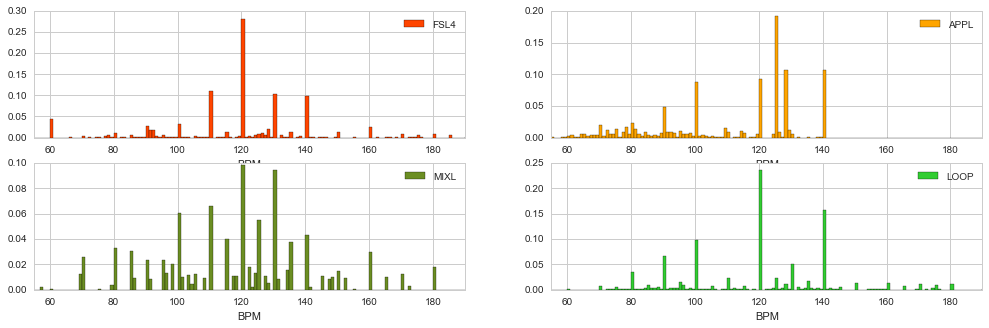

In [18]:
fig1, axs = plt.subplots(2, 2, figsize=(17, 5))
for count, dataset in enumerate(datasets):
    tempos = dataset.get_data('annotations.bpm')
    min_tempo = 30
    max_tempo = 300
    ax = axs[count/2,count%2]
    ax.hist(tempos, bins=max_tempo-min_tempo, range=(min_tempo,max_tempo), normed=True, label=dataset.short_name, color=COLORS[count])
    ax.set_xlabel('BPM')
    ax.set_xlim((55, 190))
    ax.legend()
fig1.savefig(os.path.join(settings.TEMPO_ESTIMATION_OUT_PATH, 'dataset_bpm_histograms.pdf'))
plt.show()


## PDF of sounds' duration

Maximum peak position and values (sound duration) - FSL4:
2.00 (0.83), 8.01 (0.55), 4.00 (0.43), 1.72 (0.30), 5.25 (0.30), 14.77 (0.28), 16.00 (0.19), 8.73 (0.19)
Maximum peak position and values (sound duration) - APPL:
3.90 (0.96), 3.48 (0.75), 7.73 (0.70), 7.57 (0.63), 4.06 (0.58), 4.80 (0.47), 5.39 (0.29), 8.05 (0.20)
Maximum peak position and values (sound duration) - MIXL:
3.70 (0.34), 7.39 (0.33), 9.61 (0.33), 13.71 (0.30), 8.01 (0.26), 12.01 (0.24), 7.69 (0.23), 4.36 (0.20)
Maximum peak position and values (sound duration) - LOOP:
8.05 (0.67), 6.91 (0.40), 4.04 (0.27), 3.46 (0.24), 9.65 (0.24), 10.71 (0.22), 16.04 (0.20), 13.75 (0.19)


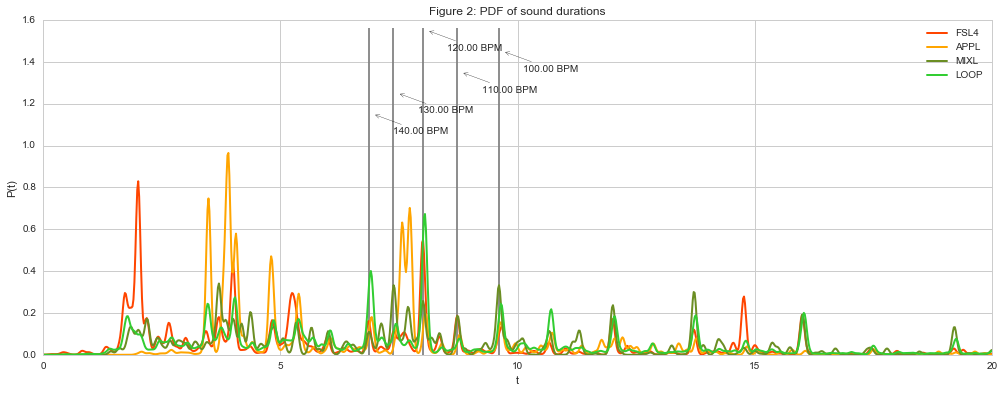

In [5]:
fig2, ax2 = plt.subplots(1, 1, figsize=(17, 6))
for count, dataset in enumerate(datasets):
    sound_durations = dataset.get_data('analysis.basic_audio_properties.duration')
    sound_durations = np.array(sound_durations)
    kde = gaussian_kde(sound_durations, bw_method=0.05 / sound_durations.std(ddof=1))
    x_grid = np.linspace(0.0, 20.0, 1000)
    x = kde.evaluate(x_grid)
    ax2.plot(x_grid, x, color=COLORS[count], linewidth=2.0, label=dataset.short_name)
    x_peaks = detect_n_max_peaks(x, n=8)
    print 'Maximum peak position and values (sound duration) - %s:' % dataset.short_name
    print ', '.join(['%.2f (%.2f)' % (x_grid[peak_pos], x[peak_pos]) for peak_pos in x_peaks])
    
ax2.set_title('Figure 2: PDF of sound durations')
ax2.set_xlabel('t')
ax2.set_ylabel('P(t)')
ax2.legend()
for count, peak_position in enumerate([8.0, 9.6, 8.72, 7.38, 6.86]):
    # Annotate meaning of peak positions # [1.75, 3.48, 4.03, 4.83, 6.91, 5.39, 8.03, 9.63, 12.0, 13.73]
    estimate_bpm = int(round(60.0/peak_position * 16))
    if 60 <= estimate_bpm <= 200:
        ax2.vlines(peak_position, 0, 1.56, label='tick', color='gray')
        label = '%.2f BPM' % estimate_bpm
        ax2.annotate(label, xy=(peak_position + 0.1, 1.55 - count * 0.1), xycoords='data',
                     xytext=(20, -20), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->"))